**SETUP**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.1 MB/s eta 0:00:00


**PREPROCESSING DATA**

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
import tensorflow as tf
import random
from tensorflow.keras.utils import to_categorical

# loading data
data = read_csv('/content/drive/Shareddrives/Di Ricco_Barbieri_Cavedoni/whole_data_15.csv')
data = data.sample(frac=1, random_state=random.seed())
data = data[:60000]

X = data.iloc[:, 7:]
y = data.iloc[:, 1]

num_features = 18
time_steps = 10

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_arr = X_train.values
X_test_arr = X_test.values

X_train_arr = X_train_arr.reshape(-1, time_steps, 18) #X_train_arr = X_train_arr.reshape((X_train.shape[0]//time_steps, time_steps, 18))
X_test_arr = X_test_arr.reshape(-1, time_steps, 18) #X_test_arr = X_test_arr.reshape((X_test.shape[0]//time_steps, time_steps, 18))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_arr.reshape(-1, num_features))
X_test_scaled = scaler.transform(X_test_arr.reshape(-1, num_features))

# riportare i dati alla forma originale
X_train_scaled = X_train_scaled.reshape((-1, time_steps, num_features))
X_test_scaled = X_test_scaled.reshape((-1, time_steps, num_features))

**MODEL**

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# defining the model
model = Sequential()

# Conv and Pooling layers
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(time_steps, num_features)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.01))

# Flattening
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.1, batch_size=10, epochs=20, verbose=1, callbacks=[early_stopping], shuffle = True)

y_test = y_test[:X_test_scaled.shape[0]]

eval_result =  model.evaluate(X_test_scaled, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/20
432/432 [==============================] - 2s 3ms/step - loss: 1.2092 - accuracy: 0.4023 - val_loss: 1.1528 - val_accuracy: 0.3958
Epoch 2/20
432/432 [==============================] - 1s 2ms/step - loss: 1.1347 - accuracy: 0.4481 - val_loss: 1.1506 - val_accuracy: 0.4000
Epoch 3/20
432/432 [==============================] - 1s 2ms/step - loss: 1.1057 - accuracy: 0.4678 - val_loss: 1.1924 - val_accuracy: 0.4104
Epoch 4/20
432/432 [==============================] - 1s 2ms/step - loss: 1.0780 - accuracy: 0.4880 - val_loss: 1.1711 - val_accuracy: 0.3771
Epoch 5/20
38/38 [==============================] - 0s 2ms/step - loss: 1.1729 - accuracy: 0.4058
[test loss, test accuracy]: [1.1728912591934204, 0.40583333373069763]


**VALIDATION GRAPHS / EARLY STOPPING**

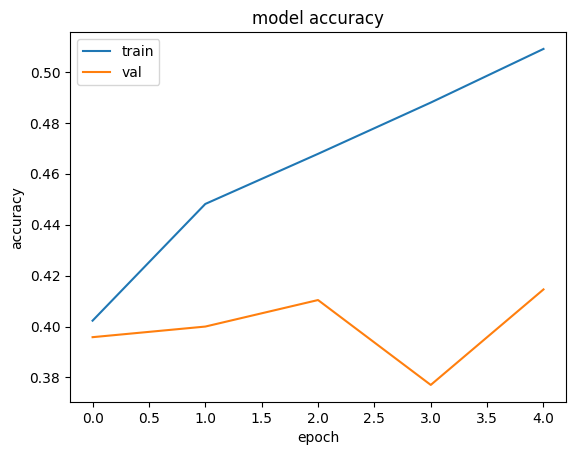

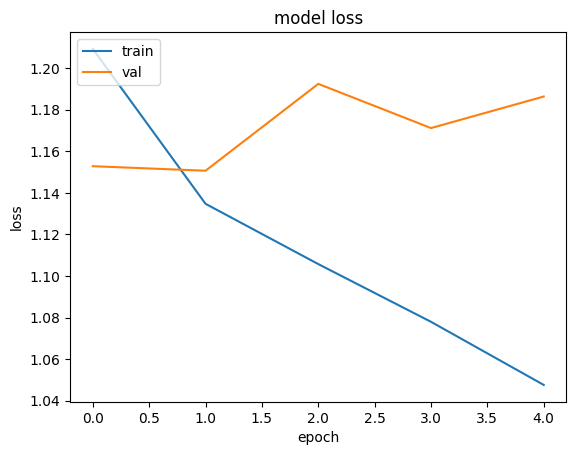

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**TUNING**


In [18]:
import kerastuner.tuners as kt
from tensorflow import keras

def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(hp.Int('num_filters_conv', min_value=5, max_value=50, step=5),
                                    hp.Int('kernel_size_conv', min_value=1, max_value=10, step=2),
                                    activation=hp.Choice('activation_conv', values=['softmax', 'relu', 'sigmoid']),
                                    input_shape=(time_steps, num_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=hp.Int('pool_size', min_value=1, max_value=5, step=2)))
    model.add(layers.Dropout(hp.Choice(name='Dropout_Rate', values=[0.1, 0.01, 0.0])))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=hp.Choice(name='units_Dense', values=[100, 500, 1000]), activation=hp.Choice('activation_dense', values=['softmax', 'relu', 'sigmoid'])))
    model.add(tf.keras.layers.Dense(5))

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model



tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=10,
                     factor=3,
                     project_name='09_kerasTuner')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.1, batch_size=10, epochs=20, verbose=1, callbacks=[early_stopping], shuffle = True)


print("Migliori iperparametri")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


y_test = y_test[:X_test_scaled.shape[0]]
eval_result =  model.evaluate(X_test_scaled, y_test)
print("[test loss, test accuracy]:", eval_result)

Trial 22 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.4270833432674408
Total elapsed time: 00h 00m 54s
Epoch 1/20
432/432 [==============================] - 2s 3ms/step - loss: 0.1362 - accuracy: 0.3903 - val_loss: 0.1284 - val_accuracy: 0.4333
Epoch 2/20
432/432 [==============================] - 1s 2ms/step - loss: 0.1335 - accuracy: 0.4076 - val_loss: 0.1292 - val_accuracy: 0.4104
Epoch 3/20
432/432 [==============================] - 1s 2ms/step - loss: 0.1341 - accuracy: 0.4042 - val_loss: 0.1294 - val_accuracy: 0.4125
Epoch 4/20
432/432 [==============================] - 1s 2ms/step - loss: 0.1326 - accuracy: 0.4065 - val_loss: 0.1307 - val_accuracy: 0.4000
Migliori iperparametri
num_filters_conv: 20
kernel_size_conv: 1
activation_conv: sigmoid
pool_size: 5
Dropout_Rate: 0.01
units_Dense: 100
activation_dense: sigmoid
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
38/38 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.4233
